# Entity embedding using t-SNE

We have been discussing some of the possible ways to embed categorical features: [Kernel PCA](PCA.ipynb) and [Spectral Encoding](spectral-encoding-of-categorical-features.ipynb). The goal is to embed categorical features in a low dimensional space. The advantage is that dramatically reduce overfitting, but we also lose some information and make the learning more difficult if the embedding is chosen incorrectly. In order to increase the quality of embedding, we use the category similarity information (that we can set *a priori* or by computing the similarity of conditional probability distribution). Kernel PCA method is also using the probability distribution of the categorical variable, whereas the Spectral Encoding does not.  For completeness, we will also use t-SNE method and we can discuss its advantages and disadvantages.

t-SNE stands for [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), and was originally proposed for visualization of high-dimensional data. As opposed to PCA, it is a non-linear method, and its goal is to preserve similarity between the data points. It introduces a non-linear transformation from the original variable $x$ to a low-dimensional variable $y$, and it models the similarity between data points using Student t-Distribution

$$ q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \ne l}{(1 + \|y_k - y_l\|^2)^{-1}}}   $$

The set of points $y_i$ is found by minimizing KL divergence of the distribution Q from the original distribution P:

$$ KL(P\|Q) = \sum_{i \ne j}{p_{ij}\log{\frac{p_{ij}}{q_{ij}}}}  $$

The minimization can be done using Gradient Descent. 

We will use the same kernel matrix $p_{ij}$ as we used in the other examples, and the same synthetic data, modeling days of week. Monday will be coded as 0, and Sunday as 7.

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=200)

In [25]:
random_data = np.random.random((1000,7))
#The next line makes weekend much more likely
random_data *= np.array([1,1,1,1,1,6,6]).reshape(1, -1) * random_data
one_hot_encoded = (random_data == random_data.max(axis=1).reshape(-1, 1)).astype('int')
one_hot_encoded.sum(axis=0)

array([ 23,  19,  15,  19,  22, 429, 473])

Here we deliberately added more data for Saturday and Sunday to see how t-SNE will take into account the probability distribution of the original data. To remind you, Laplacian method is not influenced by the the source data probability distribution, whereas PCA and kernel PCA are.

The Kernel function is the same as in the previous examples

In [26]:
kernel_matrix = np.array([[.5, 0.9, 0.8, 0.7, 0.5, 0.1, 0.3], 
                        [0, .5, 0.9, 0.8, 0.5, 0.1, 0.2],
                        [0,0,.5,0.9, 0.5, 0.1, 0.2], 
                        [0,0,0,.5,.6, .1, .2], 
                        [0,0,0,0,.5,0.7,.5], 
                        [0,0,0,0,0,.5,.8],
                        [0,0,0,0,0,0,.5]])
kernel_matrix = kernel_matrix + kernel_matrix.T
kernel_matrix

array([[1. , 0.9, 0.8, 0.7, 0.5, 0.1, 0.3],
       [0.9, 1. , 0.9, 0.8, 0.5, 0.1, 0.2],
       [0.8, 0.9, 1. , 0.9, 0.5, 0.1, 0.2],
       [0.7, 0.8, 0.9, 1. , 0.6, 0.1, 0.2],
       [0.5, 0.5, 0.5, 0.6, 1. , 0.7, 0.5],
       [0.1, 0.1, 0.1, 0.1, 0.7, 1. , 0.8],
       [0.3, 0.2, 0.2, 0.2, 0.5, 0.8, 1. ]])

Scikit-learn implementation of t-SNE actually wants me to provide metric function instead, so we transform our kernel matrix back to distance matrix

In [27]:
sigma = 1.0
distance = -2 * sigma * np.log(kernel_matrix)
distance


array([[-0.        ,  0.21072103,  0.4462871 ,  0.71334989,  1.38629436,  4.60517019,  2.40794561],
       [ 0.21072103, -0.        ,  0.21072103,  0.4462871 ,  1.38629436,  4.60517019,  3.21887582],
       [ 0.4462871 ,  0.21072103, -0.        ,  0.21072103,  1.38629436,  4.60517019,  3.21887582],
       [ 0.71334989,  0.4462871 ,  0.21072103, -0.        ,  1.02165125,  4.60517019,  3.21887582],
       [ 1.38629436,  1.38629436,  1.38629436,  1.02165125, -0.        ,  0.71334989,  1.38629436],
       [ 4.60517019,  4.60517019,  4.60517019,  4.60517019,  0.71334989, -0.        ,  0.4462871 ],
       [ 2.40794561,  3.21887582,  3.21887582,  3.21887582,  1.38629436,  0.4462871 , -0.        ]])

In [28]:
def metric_function(x1, x2):
    return x1.T @ distance @ x2

In [29]:
from sklearn.manifold import TSNE
%matplotlib inline
import seaborn as sns

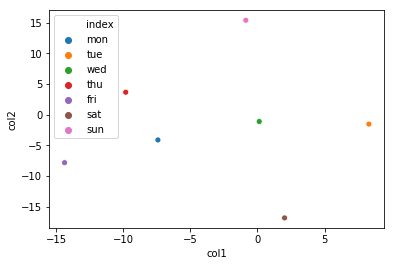

In [30]:
algorithm = TSNE(n_components=2)
model = algorithm.fit(one_hot_encoded)
indices = [np.nonzero(one_hot_encoded[:,k] == 1)[0][0] for k in range(7)]
indices = np.array(indices)
sample = model.embedding_[indices]

category_vector_frame=pd.DataFrame(sample, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'], 
                                   columns=['col1', 'col2']).reset_index()
sns.scatterplot(data=category_vector_frame, x='col1', y='col2', hue='index');

In this first example we used t-SNE without a kernel, meaning that the distance between all days of the week is 1. This is what you would get by just using 1-hot encoding. Note, that the embeddings seem to be spread  randomly, and this is a difference from PCA, which even in the absence of the kernel uses the initial data probability distribution to embed the data in such a way, that would maximize their linear separability. Let's see what results we get if we use kernel function

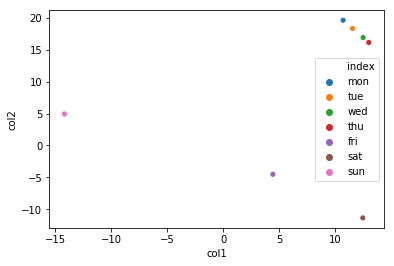

In [31]:
algorithm = TSNE(n_components=2, metric=metric_function)
model = algorithm.fit(one_hot_encoded)
indices = [np.nonzero(one_hot_encoded[:,k] == 1)[0][0] for k in range(7)]
indices = np.array(indices)
sample = model.embedding_[indices]

category_vector_frame=pd.DataFrame(sample, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'], 
                                   columns=['col1', 'col2']).reset_index()
sns.scatterplot(data=category_vector_frame, x='col1', y='col2', hue='index');

Here results are more meaningful. Monday through Thursday are grouped together to preserve their similarity. Friday, Saturday and Sunday are far apart from each other and from the other days. It is interesting to see that Friday is closer to Sunday than Saturday.

## Conclusion and discussion

t-SNE is one of the options for category embedding. Generally, t-SNE does not generalize (because it will not be able to map unknown data), but for categorical features it does not matter, because the new data will have one of the existing categories. A bigger problem is that it will not work without a kernel, as opposed to PCA which will give reasonable results even if kernel is not given. Just like Kernel PCA, it is using probability distribution to map the data, even though in a different way. If Kernel PCA is trying to achieve smoothness in the resulting vector space, t-SNE cares more about preserving similarity. This will probably guide your decision which method is more appropriate for your model